# Discretization Classification 2.0(Template) - KFold
## Author: Ming

In [37]:
#Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.calibration import CalibratedClassifierCV

#Discretization
from mdlp.discretization import MDLP
from caimcaim import CAIMD
from scorecardbundle.feature_discretization import ChiMerge as cm
from reportgen import preprocessing #Chimerge


from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix

from threading import Thread, Lock
lock = Lock()

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

#Import Our Class
%run "TEJ Classification Package.ipynb"

## Import Data

In [38]:
# Load Data
data_name = "Bankruptcy"
#Fast: Japanese_Credit Australian_Original Germany_Original Japanese_Bankrupt 
#Slow: USA_Bankrupt

#Discretize Good: Kaggle Tsai Bankruptcy Australia JPNCredit
#
if data_name == "Tsai_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Tsai_BankruptcyData()
elif  data_name == "Germany_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData()
elif  data_name == "Germany_700-300(Random)":
    germanData_data_sample, discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData_Dataframe()
elif  data_name == "Australian_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData()
elif  data_name == "Australian_Normalize(Old)":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Normalize()
elif  data_name == "Australian_(Dis5Column)Without12":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Different_Continuous_Column()
elif  data_name == "GiveMeSomeCredit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_GiveMeSomeCredit_CreditData() 
elif  data_name == "Japanese_Credit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_CreditData() 
elif  data_name == "Japanese_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_BankruptData() 
elif  data_name == "USA_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_USA_BankruptData()
elif  data_name == "Bankruptcy":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Bankruptcy_Data() 
elif  data_name == "TEJCN":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_TEJCN_Data() 
elif  data_name == "PAKDD":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_PAKDD_Data() 
    
# # Select Data
# data_list = tsaiData_data
# target_list = tsaiData_target
# discretize_coloumn = continuous_coloumn

# Sampling
# large = germanData_data_sample.loc[germanData_data_sample['default'] == 1]
# small = germanData_data_sample.loc[germanData_data_sample['default'] == 2]
# large = large.sample(n=300)
# germanData_data = pd.concat([large, small])
# germanData_data = germanData_data.sample(frac=1).reset_index(drop=True)
# data_list = germanData_data[[i for i in germanData_data.columns if i != 'default']].values
# target_list = germanData_data[[i for i in germanData_data.columns if i == 'default']].values


# Declare Result List (Alogorithm, fold, ACC, AUC)
evaluation_result_list = []

In [39]:
print ("資料筆數 ::", data_list.shape[0])
print ("特徵數量(不含Target) ::", data_list.shape[1])

資料筆數 :: 1321
特徵數量(不含Target) :: 16


大類:1 小類2

In [40]:
unique, counts = np.unique(target_list, return_counts=True)
dict(zip(unique, counts))

{1: 697, 2: 624}

a = pd.DataFrame(data_list)

for idx,classifi in enumerate(a):
    if a[idx].nunique()>10:
        print(str(idx)+"_"+str(a[idx].nunique()))
        #print(str(idx))

## Select Specific Features to Discretization + Discretization Method (MDLP、CAIM、ChiMerge)

In [41]:
class Discretization:
    def __init__(self, training_data, training_target, discretize_coloumn):
        self.training_data = training_data
        self.training_target = training_target
        self.discretize_coloumn = discretize_coloumn
        self.transformer_MDLP = MDLP()
        self.transformer_CAIMD = CAIMD()
        self.transformer_ChiMerge_SC = cm.ChiMerge(output_dataframe=True)
        self.transformer_ChiMerge_RG = preprocessing.Discretization(method='chimerge')

    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
        selectData_list = self.training_data[:,idx_IN_columns]
        disSelectData_list = self.training_data[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
        
    def MDLP(self,selectData_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def MDLP_transform(self,selectData_test_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.transform(selectData_test_list)
        return selectDataDiscretiz_list

    def CAIMD(self,selectData_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def CAIMD_transform(self,selectData_test_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.transform(selectData_test_list)
        return selectDataDiscretiz_list
    
    def ChiMerge_SC(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_SC_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def Box_Transform(self,discretize_list):
        for i in discretize_list.columns:
            replace_coloumn = discretize_list[i].unique()
            lst = list(replace_coloumn)
            ip_dict = dict(zip(lst, range(len(lst))))
            discretize_list[i] = discretize_list[i].replace(ip_dict)
        return discretize_list
    
    def MergeFeatures(self,selectDataDiscretiz_list,disSelectData_list):  ## Merge Discretized Data with Original Data
        self.dataDiscretize_list = np.concatenate([selectDataDiscretiz_list,disSelectData_list],axis = 1)
        return self.dataDiscretize_list

## rpy2 Discretization

In [42]:
class Discretization_rpy2:
    def __init__(self, training_data, training_target, discretize_coloumn):
        self.training_data = training_data
        self.training_target = training_target
        self.discretize_coloumn = discretize_coloumn
        self.transformer_MDLP = MDLP()
        self.transformer_CAIMD = CAIMD()
        self.transformer_ChiMerge_SC = cm.ChiMerge(output_dataframe=True)
        self.transformer_ChiMerge_RG = preprocessing.Discretization(method='chimerge')

    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
        selectData_list = self.training_data[:,idx_IN_columns]
        disSelectData_list = self.training_data[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
    
     

## KFoldFuntion

In [43]:
class KFoldFuntion:
    # linear_svc,'linear_svc','baseline', data_list, target_list, fold
    def __init__(self, classifier, classifier_name, method, data_list, target_list, fold, discretize_coloumn):
        self.X = data_list
        self.y = target_list
        self.fold = fold
        self.outcomes_acc = []
        self.outcomes_auc = []
        self.outcomes_typeII = []
        self.outcomes_typeI = []
        self.fold_result_list = []
        self.outcomes_minority = []
        self.outcomes_majority = []
        self.method = method  # (Baseline, MDLP, CAIM)
        self.classifier = classifier
        self.classifier_name = classifier_name
        self.discretize_coloumn = discretize_coloumn
    
    def Classify(self):
        kf = KFold(n_splits=self.fold,random_state=np.random, shuffle=True)
        #kf = StratifiedKFold(n_splits=self.fold)
        #for train_index, test_index in kf.split(self.X,self.y):
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X[train_index], self.X[test_index] #X_train: training data X_test: testing data
            y_train, y_test = self.y[train_index], self.y[test_index] #y_train: training data answer y_test: testing data answer
            
            if self.method == 'Baseline':
                
                # Convert to Dataframe
                X_train_dataframe = pd.DataFrame(X_train)
                X_test_dataframe  = pd.DataFrame(X_test)
                y_train_dataframe = pd.DataFrame(y_train)
                y_test_dataframe  = pd.DataFrame(y_test)
                predictions,proba = self.Classification(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe)
                self.StoreFoldResult(y_test_dataframe,predictions,proba)
            else:

                # -------------------------------------Discretize Training Data--------------------------------------
                # Declare Training Data Discretizer_rpy2  ------OK
                discretize_train = Discretization_rpy2(X_train,y_train,self.discretize_coloumn)

                # Select Continuous Feature (Training Data Continuous Feature)   ------OK
                ## Return: List of data
                X_train_continuousData_list, X_train_catrgorialData_list  = discretize_train.SelectFeatures() #Devide Discretize Coloumns

                
                # Convert data to Dataframe for R Package "Discretization"
                ## R require Select Continuous Data(X_Train_SelectData) and Target(y_Train) in the last column
                X_train_continuousData_dataframe = pd.DataFrame(X_train_continuousData_list)
                y_train_dataframe = pd.DataFrame(y_train)
    
                # Combine Select Continuous with Target
                X_y_train_continuousData_dataframe = pd.concat([X_train_continuousData_dataframe, y_train_dataframe],axis=1)
                X_y_train_continuousData_dataframe.columns = range(X_y_train_continuousData_dataframe.shape[1])
                print("[X_y_train_continuousData_dataframe]")
                print(X_y_train_continuousData_dataframe.head(5))
                
                
                # Import R Package
                discretization = importr("discretization")
                disc_Topdown = robjects.r("disc.Topdown")
                
                print("-------------------------------"+self.method+" -----------------------------")
                # Discretize (R Package)
                ## Input: pandas.DataFrame  Output: rpy2.DataFrame
                if self.method == 'MDLP_R':
                    X_y_train_disData_rpy2dataframe = discretization.mdlp(X_y_train_continuousData_dataframe)
                elif self.method == 'CAIM_R':
                    X_y_train_disData_rpy2dataframe = discretization.disc_Topdown(X_y_train_continuousData_dataframe, method=1)
                elif self.method == 'ChiMerge_R':
                    X_y_train_disData_rpy2dataframe = discretization.chiM(X_y_train_continuousData_dataframe, alpha = 0.05)
                elif self.method == 'CACC_R':
                    X_y_train_disData_rpy2dataframe = discretization.disc_Topdown(X_y_train_continuousData_dataframe, method=2)
                elif self.method == 'Chi2_R':
                    X_y_train_disData_rpy2dataframe = discretization.chi2(X_y_train_continuousData_dataframe,0.5,0.05)
                    
                # Transfer rpy2.DataFrame to pandas.DataFrame
                X_y_train_disData_dataframe = pandas2ri.ri2py(X_y_train_disData_rpy2dataframe[1])
                
                
                print("[X_y_train_disData_dataframe]")
                print(X_y_train_disData_dataframe.head(5))
                
                # Select the data(without target) in Combine_X_y_train_dis_dataframe 
                X_train_disData_dataframe = X_y_train_disData_dataframe.iloc[:,:-1]
                print("[X_train_disData_dataframe]")
                print(X_train_disData_dataframe.head(5))
                
                
                # Merge dis_feature & categeorial_feature
                X_train_categorialData_dataframe = pd.DataFrame(X_train_catrgorialData_list)
                print("[X_train_categorialData_dataframe]")
                print(X_train_categorialData_dataframe.head(5))
                
                Discretize_X_train_dataframe = pd.concat([X_train_disData_dataframe, X_train_categorialData_dataframe],axis = 1)
                Discretize_X_train_dataframe.columns = range(Discretize_X_train_dataframe.shape[1])
                print("[Discretize_X_train_dataframe]")
                print(Discretize_X_train_dataframe.head(5))
                
                
                # --------------------------------------Discretize Testing Data----------------------------------------------------
                
                # Enable Cutpoint for X_test (No Target)
                
                ## Declare Training Data Discretizer_rpy2  ------OK
                discretize_test = Discretization_rpy2(X_test,y_test,discretize_coloumn)
                
                ## Select Continuous Feature (Testing Data Continuous Feature)   ------OK
                ## Return: List of data
                X_test_continuousData_list, X_test_catrgorialData_list  = discretize_test.SelectFeatures() #Devide Discretize Coloumns
                
                
                ## Prepare X_test to enable cutpoint
                X_test_continuousData_dataframe  = pd.DataFrame(X_test_continuousData_list)
                print("X_test_continuousData_dataframe")
                print(X_test_continuousData_dataframe.head(5))
                
                ## Get Cutpoint (Transfer to numpy array)
                cutpoint_bins = X_y_train_disData_rpy2dataframe[0]
                #cutpoint_bins = np.array(cutpoint)
                #print("Original Cutbins")
                #print(cutpoint_bins)
                
                
                ## Declare dataframe for store data after discretize
                X_test_disData_dataframe = pd.DataFrame()

                
                for idx, val in enumerate(X_test_continuousData_dataframe):
                    if cutpoint_bins[idx][0] == "All":
                        print(str(idx)+"_ALL")
                        X_test_disData_dataframe[idx] = pd.cut(X_test_continuousData_dataframe.iloc[:,idx], bins =1 , labels = [1],include_lowest=True )    
                    else:        
                        print(str(idx)+"_NOTALL")
                        cutpoint_bins[idx] = np.sort(cutpoint_bins[idx])
                        #print(type(cutpoint_bins[idx]))
                        cutpoint_with_infiniti = np.insert (np.insert(cutpoint_bins[idx],0, (-np.inf),0),len(cutpoint_bins[idx])+1,(np.inf))
                        cutpoint_labels = list(range(1, len(cutpoint_with_infiniti)))
                        #print(cutpoint_labels)
                        
                        X_test_disData_dataframe[idx] = pd.cut(X_test_continuousData_dataframe.iloc[:,idx], bins = cutpoint_with_infiniti,labels=cutpoint_labels,include_lowest=True)
                print("X_test_disData_dataframe")
                print(X_test_disData_dataframe.head(5))    
                    
                    
                # Merge dis_feature & categeorial_feature
                X_test_categorialData_dataframe = pd.DataFrame(X_test_catrgorialData_list)
                print("X_test_categorialData_dataframe")
                print(X_test_categorialData_dataframe.head(5))
                
                Discretize_X_test_dataframe = pd.concat([X_test_disData_dataframe, X_test_categorialData_dataframe],axis=1)
                Discretize_X_test_dataframe.columns = range(Discretize_X_test_dataframe.shape[1])
                
                print("Discretize_X_test_dataframe")
                print(Discretize_X_test_dataframe.head(5))
                
        
                # Convert Target to Dataframe
                y_train_dataframe = pd.DataFrame(y_train)
                y_test_dataframe = pd.DataFrame(y_test)
                

                # Prediction (Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe)
                predictions,proba = self.Classification(Discretize_X_train_dataframe,y_train_dataframe,
                                                        Discretize_X_test_dataframe,y_test_dataframe)
                self.StoreFoldResult(y_test_dataframe,predictions,proba)
                
                print("-------------------------------NEXT ROUND-----------------------------")
        return self.PrintTotalResult()   
                      
    def Classification(self,X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe):
        
         # Convert Dataframe column from int to str (for xgboost)
        X_train_dataframe.columns = X_train_dataframe.columns.astype(str)
        y_train_dataframe.columns = y_train_dataframe.columns.astype(str)
        X_test_dataframe.columns = X_test_dataframe.columns.astype(str)
        y_test_dataframe.columns = y_test_dataframe.columns.astype(str)
        
        X_train_dataframe = X_train_dataframe.astype('float')
        y_train_dataframe = y_train_dataframe.astype('float')
        X_test_dataframe = X_test_dataframe.astype('float')
        y_test_dataframe = y_test_dataframe.astype('float')
        
        
        clf = self.classifier
        clf.fit(X_train_dataframe, y_train_dataframe["0"].ravel())
        predictions = clf.predict(X_test_dataframe)
        proba = clf.predict_proba(X_test_dataframe)[:, 1]
        return predictions,proba

    
    def StoreFoldResult(self,y_test_dataframe,predictions,proba):
        
        #Accuracy Score
        accuracy = accuracy_score(y_test_dataframe, predictions)
        self.outcomes_acc.append(accuracy)
        
        #AUC Score
        auc = roc_auc_score(y_test_dataframe, proba)
        self.outcomes_auc.append(auc)
        
        #Type II Error
        TN, FP, FN, TP = confusion_matrix(y_test_dataframe, predictions).ravel()
        typeII = FN/(TP+FN)
        typeI = FP/(FP+TN)
        self.outcomes_typeII.append(typeII)
        self.outcomes_typeI.append(typeI)
        
        #Majority, Minority (Count)
        unique, counts = np.unique(y_test_dataframe, return_counts=True)
        dict(zip(unique, counts))
        
        proportion = np.unique(y_test_dataframe, return_counts=True)
        majority_proportion = proportion[1][0]/(self.X.shape[0]/self.fold)
        minority_proportion = proportion[1][1]/(self.X.shape[0]/self.fold)
        self.outcomes_majority.append(proportion[1][0])
        self.outcomes_minority.append(proportion[1][1])

        
        # Plot fold_result_list 
        each_fold_result_list = [accuracy,auc,typeI,typeII,majority_proportion,minority_proportion]
        self.fold_result_list.append(each_fold_result_list)
    
    def PrintTotalResult(self):
        
        mean_outcome_acc = np.mean(self.outcomes_acc)
        print("Mean Accuracy: {0}".format(mean_outcome_acc))
        print("Mean Accuracy"+ str(self.outcomes_acc))
        
        mean_outcome_auc = np.mean(self.outcomes_auc)
        print("Mean Auc: {0}".format(mean_outcome_auc))
        print("Mean Auc"+ str(self.outcomes_auc))
        
        mean_outcomes_typeII = np.mean(self.outcomes_typeII)
        print("Mean TypeII: {0}".format(mean_outcomes_typeII))
        print("Mean TypeII"+ str(self.outcomes_typeII))
        
        mean_outcomes_typeI = np.mean(self.outcomes_typeI)
        print("Mean TypeI: {0}".format(mean_outcomes_typeI))
        print("Mean TypeI"+ str(self.outcomes_typeI))
        
        lock.acquire()
        
        # Print Each Fold Plot
        self.PrintPlotEachFold(self.fold_result_list,"Result")
        
        lock.release()
        
        return mean_outcome_acc, mean_outcome_auc, mean_outcomes_typeI, mean_outcomes_typeII
    
    def PrintPlotEachFold(self,plot_data,metrics_name):
        
        #Trasnfer Type 
        plot_data = np.array(plot_data)
        
        #Set Each Line Data
        plt.plot(plot_data[:,0],label='acc')
        plt.plot(plot_data[:,1],label='auc')
        plt.plot(plot_data[:,2],label='type I')
        plt.plot(plot_data[:,3],label='type II')
        plt.plot(plot_data[:,4],label='maj', marker='o')
        plt.plot(plot_data[:,5],label='min', marker='o')
        
        #Set Graph Information
        title = '{metrics_name} with {fold} folds-{method}-{classifier_name}'.format(
            metrics_name=metrics_name, fold=self.fold,method=self.method,classifier_name=self.classifier_name )
        plt.title(title)
        plt.xlabel('Folds')
        plt.ylabel('percertange')
        plt.legend(loc='upper right')
        plt.show()
    

## Graph

In [44]:
def CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC,result_10times_CACC,result_10times_Chi2):
    #Labels
    labels = ['ACC', 'AUC', 'TYPEI', 'TYPEII']
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    result_10times_baseline_mean = np.around( np.mean(result_10times_baseline, axis=0), decimals=3)
    result_10times_MDLP_mean =  np.around( np.mean(result_10times_MDLP, axis=0), decimals=3)
    result_10times_CAIM_mean =  np.around( np.mean(result_10times_CAIM, axis=0), decimals=3)
    result_10times_ChiMerge_SC_mean =  np.around( np.mean(result_10times_ChiMerge_SC, axis=0), decimals=3)
    result_10times_CACC_mean =  np.around( np.mean(result_10times_CACC, axis=0), decimals=3)
    result_10times_Chi2_mean =  np.around( np.mean(result_10times_Chi2, axis=0), decimals=3)
    #result_10times_ChiMerge_RG_mean =  np.around( np.mean(result_10times_ChiMerge_RG, axis=0), decimals=3)

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x , result_10times_baseline_mean, width, label='Baseline')
    rects2 = ax.bar(x +width, result_10times_MDLP_mean, width, label='MDLP_R')
    rects3 = ax.bar(x +width*2, result_10times_CAIM_mean, width, label='CAIM_R')
    rects4 = ax.bar(x +width*3, result_10times_ChiMerge_SC_mean, width, label='ChiMerge_R')
    rects5 = ax.bar(x +width*4, result_10times_CACC_mean, width, label='CACC_R')
    rects6 = ax.bar(x +width*5, result_10times_Chi2_mean, width, label='Chi2_R')
    #rects5 = ax.bar(x +width*4, result_10times_ChiMerge_RG_mean, width, label='ChiMerge_RG')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    data_name, clf_name, rounds
    title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
    ax.set_title(title)
    ax.set_xticks(x+width*2)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1, 0.5))

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', size = 12)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)
    autolabel(rects6)
    
    fig.tight_layout()
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    file_name = "results/{title}_{file_timeA}.png".format(file_timeA = file_time, title= title)
    print(title)
    fig.savefig(file_name)
    plt.show()

In [45]:
def ResultEachMethodLineChart(result, method_name,data_name, classifier_name):
    result = np.array(result)
    
    plt.plot(result[:,0], label='Acc', marker='o')
    plt.plot(result[:,1], label='Auc', marker='o')
    plt.plot(result[:,2], label='TypeI', marker='o')
    plt.plot(result[:,3], label='TypeII', marker='o')
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.ylabel('Percertange')
    plt.xlabel('Rounds')
    title = 'Each Rounds-{data_name}-{method_name}-{classifier_name}'.format(data_name=data_name,method_name=method_name,classifier_name=classifier_name)
    plt.title(title)
    
    
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    #plt.savefig('results/{title}_{file_timeA}.png'.format(file_timeA = file_time, title= title, method_name=method_name, classifier_name=classifier_name), bbox_inches='tight')
    plt.show()
    
    plt.close

## Import Classification Package

In [46]:
from sklearn.svm import SVC, LinearSVC , libsvm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from logitboost import LogitBoost
from sklearn.ensemble import AdaBoostClassifier

## Start Classify

## Run 10 Times


程式開始
Mean Accuracy: 0.9068953687821611
Mean Accuracy[0.8981132075471698, 0.9015151515151515, 0.9166666666666666, 0.9053030303030303, 0.9128787878787878]
Mean Auc: 0.9713788031626642
Mean Auc[0.9683299156983368, 0.9750336986461936, 0.9781135110294117, 0.9683131407269339, 0.9671037497124452]
Mean TypeII: 0.08269170176033944
Mean TypeII[0.09022556390977443, 0.04424778761061947, 0.08823529411764706, 0.10344827586206896, 0.0873015873015873]
Mean TypeI: 0.10112571417909022
Mean TypeI[0.11363636363636363, 0.1390728476821192, 0.078125, 0.08783783783783784, 0.08695652173913043]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


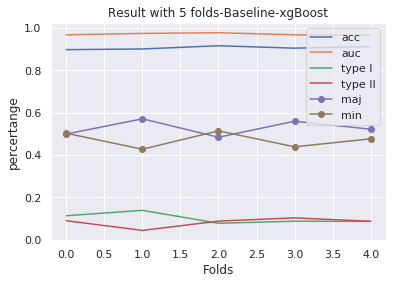

Mean : [0.90689537 0.9713788  0.10112571 0.0826917 ]
[X_y_train_continuousData_dataframe]
    0    1     2    3     4    5    6    7     8    9     10    11   12   13  \
0 7.00 1.73 -4.34 0.00 65.44 0.00 0.00 0.17 -1.01 0.00 -1.18 -1.01 0.00 0.00   
1 6.00 2.61 -4.25 0.00 64.98 0.00 0.00 0.18 -0.53 0.00 -0.12 -0.53 0.00 0.00   
2 5.00 4.19 -4.23 0.00 66.26 0.00 0.00 0.11 -0.41 0.00 -0.45 -0.41 0.00 0.00   
3 8.00 0.00 -1.45 0.00  0.06 0.00 0.00 0.00 -0.06 0.00 -0.06 -0.06 0.00 0.00   
4 7.00 0.00 -1.43 0.00  0.00 0.00 0.00 0.00  0.00 0.00 -1.34  0.00 0.00 0.00   

    14   15  16  
0 4.41 0.50   1  
1 7.35 0.75   1  
2 4.11 0.65   1  
3 0.03 0.09   2  
4 0.16 0.10   2  
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   2   1   1   2   2   2    4    2    1    1    1    2    1
1   1   1   1   1   2   1   1   2   2   2    4    2    1    1    1    2    1
2   1   1   1   1   2   1   1   2   2   2    4    2    1    1    1    2    1
3   1   1   2   1   1   1   1   1   2   2    4    2    1    1    1    1    2
4   1   1   2   1   1   1   1   1   2   2    4    2    1    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   2   1   1   2   2   2    4    2    1    1    1    2
1   1   1   1   1   2   1   1   2   2   2    4    2    1    1    1    2
2   1   1   1   1   2   1   1   2   2   2    4    2    1    1    1    2
3   1   1   2   1   1   1   1   1   2   2    4    2    1    1    1    1
4   1   1   2   1   1   1   1   1   2   2    4    2    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   2   1   1   2   2   2    3    2    1    1    1    2    1
1   1   1   1   1   2   1   1   2   2   2    3    2    1    1    1    2    1
2   1   1   1   1   2   1   1   2   2   2    3    2    1    1    1    2    1
3   1   1   1   1   2   1   1   2   2   2    3    2    1    1    1    2    1
4   1   1   2   1   1   1   1   1   2   2    3    2    1    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   2   1   1   2   2   2    3    2    1    1    1    2
1   1   1   1   1   2   1   1   2   2   2    3    2    1    1    1    2
2   1   1   1   1   2   1   1   2   2   2    3    2    1    1    1    2
3   1   1   1   1   2   1   1   2   2   2    3    2    1    1    1    2
4   1   1   2   1   1   1   1   1   2   2    3    2    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   2   1   1   2   3   2    4    3    1    1    1    2    1
1   1   1   1   1   2   1   1   2   3   2    4    3    1    1    1    2    1
2   1   1   1   1   2   1   1   2   3   2    4    3    1    1    1    2    1
3   1   1   3   1   1   1   1   1   3   2    4    3    1    1    1    1    2
4   1   1   3   1   1   1   1   1   3   2    4    3    1    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   2   1   1   2   3   2    4    3    1    1    1    2
1   1   1   1   1   2   1   1   2   3   2    4    3    1    1    1    2
2   1   1   1   1   2   1   1   2   3   2    4    3    1    1    1    2
3   1   1   3   1   1   1   1   1   3   2    4    3    1    1    1    1
4   1   1   3   1   1   1   1   1   3   2    4    3    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   2   1   1   2   3   2    3    3    1    1    1    2    1
1   1   1   1   1   2   1   1   2   3   2    3    3    1    1    1    2    1
2   1   1   1   1   2   1   1   2   3   2    3    3    1    1    1    2    1
3   1   1   3   1   1   1   1   1   3   2    3    3    1    1    1    1    2
4   1   1   3   1   1   1   1   1   3   2    3    3    1    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   2   1   1   2   3   2    3    3    1    1    1    2
1   1   1   1   1   2   1   1   2   3   2    3    3    1    1    1    2
2   1   1   1   1   2   1   1   2   3   2    3    3    1    1    1    2
3   1   1   3   1   1   1   1   1   3   2    3    3    1    1    1    1
4   1   1   3   1   1   1   1   1   3   2    3    3    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   2   1   1   2   2   1    3    2    1    1    1    2    1
1   1   1   1   1   2   1   1   2   2   1    3    2    1    1    1    2    1
2   1   1   1   1   2   1   1   2   2   1    3    2    1    1    1    2    1
3   1   1   2   1   2   1   1   2   2   1    3    2    1    1    1    2    1
4   1   1   2   1   1   1   1   1   2   1    3    2    1    1    1    2    1
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   2   1   1   2   2   1    3    2    1    1    1    2
1   1   1   1   1   2   1   1   2   2   1    3    2    1    1    1    2
2   1   1   1   1   2   1   1   2   2   1    3    2    1    1    1    2
3   1   1   2   1   2   1   1   2   2   1    3    2    1    1    1    2
4   1   1   2   1   1   1   1   1   2   1    3    2    1    1    1    2
[X_train_categorialData_dataframe]
Empty DataFra

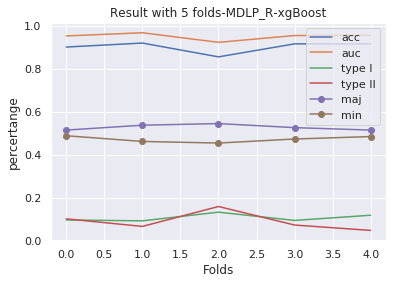

[X_y_train_continuousData_dataframe]
    0    1     2    3     4    5    6    7     8    9     10    11   12   13  \
0 6.00 2.61 -4.25 0.00 64.98 0.00 0.00 0.18 -0.53 0.00 -0.12 -0.53 0.00 0.00   
1 5.00 4.19 -4.23 0.00 66.26 0.00 0.00 0.11 -0.41 0.00 -0.45 -0.41 0.00 0.00   
2 4.00 1.84 -4.19 0.00 63.34 0.00 0.00 0.11 -0.36 0.00 -0.40 -0.36 0.00 0.00   
3 8.00 0.00 -1.45 0.00  0.06 0.00 0.00 0.00 -0.06 0.00 -0.06 -0.06 0.00 0.00   
4 7.00 0.00 -1.43 0.00  0.00 0.00 0.00 0.00  0.00 0.00 -1.34  0.00 0.00 0.00   

    14   15  16  
0 7.35 0.75   1  
1 4.11 0.65   1  
2 4.41 0.75   1  
3 0.03 0.09   2  
4 0.16 0.10   2  
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1    1
1   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1    1
2   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1    1
3   2   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1    2
4   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1
1   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1
2   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1
3   2   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1
4   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1    1
1   1   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1    1
2   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1    2
3   2   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1    1
4   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1    1
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1
1   1   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1
2   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1
3   2   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1
4   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1    1
1   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1    1
2   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1    1
3   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1    1
4   2   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1
1   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1
2   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1
3   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1
4   2   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1    1
1   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1    1
2   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1    1
3   2   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1    2
4   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1
1   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1
2   1   1   1   1   2   1   1   2   1   1    2    1    1    1    1    1
3   2   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1
4   1   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1    1
1   1   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1    1
2   1   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1    1
3   1   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1    1
4   2   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1
1   1   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1
2   1   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1
3   1   1   1   1   2   1   1   1   1   1    2    1    1    1    1    1
4   2   1   1   1   1   1   1   1   1   1    2    1    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

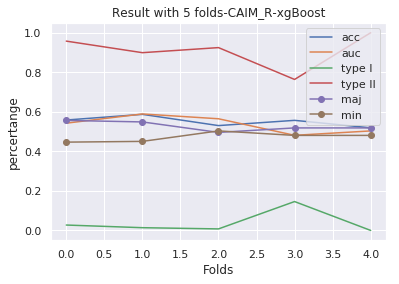

[X_y_train_continuousData_dataframe]
    0    1     2    3     4    5    6    7     8    9     10    11   12   13  \
0 7.00 1.73 -4.34 0.00 65.44 0.00 0.00 0.17 -1.01 0.00 -1.18 -1.01 0.00 0.00   
1 6.00 2.61 -4.25 0.00 64.98 0.00 0.00 0.18 -0.53 0.00 -0.12 -0.53 0.00 0.00   
2 5.00 4.19 -4.23 0.00 66.26 0.00 0.00 0.11 -0.41 0.00 -0.45 -0.41 0.00 0.00   
3 4.00 1.84 -4.19 0.00 63.34 0.00 0.00 0.11 -0.36 0.00 -0.40 -0.36 0.00 0.00   
4 7.00 0.00 -1.43 0.00  0.00 0.00 0.00 0.00  0.00 0.00 -1.34  0.00 0.00 0.00   

    14   15  16  
0 4.41 0.50   1  
1 7.35 0.75   1  
2 4.11 0.65   1  
3 4.41 0.75   1  
4 0.16 0.10   2  
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   2  19   1   1  64   1   2   6  41   5   69   41    2    1   15    7    1
1   1  23   1   1  64   1   2   6  43   5   79   43    2    1   23    8    1
2   1  29   1   1  64   1   2   5  43   5   71   43    2    1   14    7    1
3   1  21   1   1  64   1   2   5  43   5   73   43    2    1   15    8    1
4   2   1   6   1   1   1   2   1  52   5   68   52    2    1    1    2    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   2  19   1   1  64   1   2   6  41   5   69   41    2    1   15    7
1   1  23   1   1  64   1   2   6  43   5   79   43    2    1   23    8
2   1  29   1   1  64   1   2   5  43   5   71   43    2    1   14    7
3   1  21   1   1  64   1   2   5  43   5   73   43    2    1   15    8
4   2   1   6   1   1   1   2   1  52   5   68   52    2    1    1    2
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   2   8   1   1  70   1   2   6  49   7   50   49    1    1   10    7    1
1   1   9   1   1  70   1   2   6  51   7   58   51    1    1   26    9    1
2   1  15   1   1  71   1   2   5  51   7   53   51    1    1    8    7    1
3   1   8   1   1  70   1   2   5  51   7   54   51    1    1   10    9    1
4   2   1   4   1   1   1   2   1  56   7   59   56    1    1    1    2    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   2   8   1   1  70   1   2   6  49   7   50   49    1    1   10    7
1   1   9   1   1  70   1   2   6  51   7   58   51    1    1   26    9
2   1  15   1   1  71   1   2   5  51   7   53   51    1    1    8    7
3   1   8   1   1  70   1   2   5  51   7   54   51    1    1   10    9
4   2   1   4   1   1   1   2   1  56   7   59   56    1    1    1    2
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1  11   1   1  54   1   2   7  38   5   37   38    1    1   24   14    1
1   1  11   1   1  54   1   2   3  41   5   33   41    1    1   21   14    1
2   2   1   6   1   1   1   2   1  46   5   38   46    1    1    1    2    2
3   1   1   6   1   1   1   2   1  50   5   30   50    1    1    1    2    2
4   2  11   7   1  54   1   2   5  26   5   30   26    1    1   28   12    1
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1  11   1   1  54   1   2   7  38   5   37   38    1    1   24   14
1   1  11   1   1  54   1   2   3  41   5   33   41    1    1   21   14
2   2   1   6   1   1   1   2   1  46   5   38   46    1    1    1    2
3   1   1   6   1   1   1   2   1  50   5   30   50    1    1    1    2
4   2  11   7   1  54   1   2   5  26   5   30   26    1    1   28   12
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   3   1   1  73   1   2   9  48   5   57   48    2    1   23    5    1
1   1   9   1   1  73   1   2   5  54   5   63   54    2    1   21    5    1
2   2   1   6   1   1   1   2   1  57   5   70   57    2    1    1    2    2
3   1   1   6   1   1   1   2   1  61   5   56   61    2    1    1    2    2
4   2   3   6   1  73   1   2   7  32   5   46   32    2    1   40    5    1
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   3   1   1  73   1   2   9  48   5   57   48    2    1   23    5
1   1   9   1   1  73   1   2   5  54   5   63   54    2    1   21    5
2   2   1   6   1   1   1   2   1  57   5   70   57    2    1    1    2
3   1   1   6   1   1   1   2   1  61   5   56   61    2    1    1    2
4   2   3   6   1  73   1   2   7  32   5   46   32    2    1   40    5
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1  13   1   1  55   1   2   9  37   3   52   37    2    1   29    2    1
1   1  19   1   1  55   1   2  11  39   3   60   39    2    1   35    3    1
2   1  25   1   1  56   1   2   5  40   3   56   40    2    1   27    2    1
3   1  15   1   1  55   1   2   5  40   3   56   40    2    1   29    3    1
4   1   1   4   1   1   1   2   1  45   3   61   45    2    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1  13   1   1  55   1   2   9  37   3   52   37    2    1   29    2
1   1  19   1   1  55   1   2  11  39   3   60   39    2    1   35    3
2   1  25   1   1  56   1   2   5  40   3   56   40    2    1   27    2
3   1  15   1   1  55   1   2   5  40   3   56   40    2    1   29    3
4   1   1   4   1   1   1   2   1  45   3   61   45    2    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

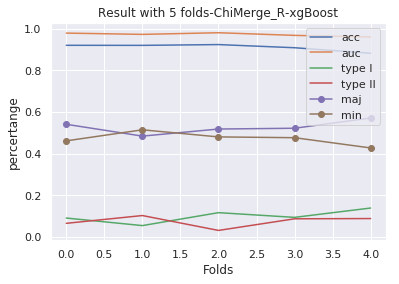

[X_y_train_continuousData_dataframe]
    0    1     2    3     4    5    6    7     8    9     10    11   12   13  \
0 7.00 1.73 -4.34 0.00 65.44 0.00 0.00 0.17 -1.01 0.00 -1.18 -1.01 0.00 0.00   
1 6.00 2.61 -4.25 0.00 64.98 0.00 0.00 0.18 -0.53 0.00 -0.12 -0.53 0.00 0.00   
2 5.00 4.19 -4.23 0.00 66.26 0.00 0.00 0.11 -0.41 0.00 -0.45 -0.41 0.00 0.00   
3 8.00 0.00 -1.45 0.00  0.06 0.00 0.00 0.00 -0.06 0.00 -0.06 -0.06 0.00 0.00   
4 7.00 0.00 -1.43 0.00  0.00 0.00 0.00 0.00  0.00 0.00 -1.34  0.00 0.00 0.00   

    14   15  16  
0 4.41 0.50   1  
1 7.35 0.75   1  
2 4.11 0.65   1  
3 0.03 0.09   2  
4 0.16 0.10   2  
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1    1
1   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1    1
2   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1    1
3   2   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1    2
4   1   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1
1   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1
2   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1
3   2   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1
4   1   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1    1
1   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1    1
2   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1    1
3   1   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1    2
4   1   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1
1   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1
2   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1
3   1   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1
4   1   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1    1
1   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1    1
2   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1    1
3   2   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1    2
4   1   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1
1   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1
2   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1
3   2   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1
4   1   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1    1
1   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1    1
2   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1    1
3   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1    1
4   2   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1
1   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1
2   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1
3   1   1   1   1   1   1   1   2   2   1    2    2    1    1    1    1
4   2   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1    1
1   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1    1
2   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1    1
3   2   1   2   1   2   1   1   2   2   1    2    2    1    1    1    1    1
4   1   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1    1
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1
1   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1
2   1   1   1   1   2   1   1   2   2   1    2    2    1    1    1    1
3   2   1   2   1   2   1   1   2   2   1    2    2    1    1    1    1
4   1   1   2   1   1   1   1   1   2   1    2    2    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

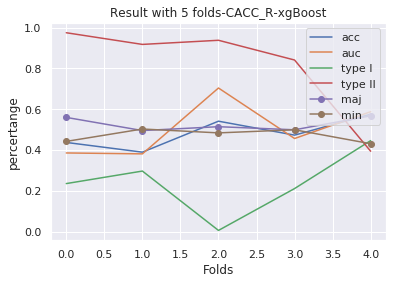

[X_y_train_continuousData_dataframe]
    0    1     2    3     4    5    6    7     8    9     10    11   12   13  \
0 7.00 1.73 -4.34 0.00 65.44 0.00 0.00 0.17 -1.01 0.00 -1.18 -1.01 0.00 0.00   
1 6.00 2.61 -4.25 0.00 64.98 0.00 0.00 0.18 -0.53 0.00 -0.12 -0.53 0.00 0.00   
2 5.00 4.19 -4.23 0.00 66.26 0.00 0.00 0.11 -0.41 0.00 -0.45 -0.41 0.00 0.00   
3 4.00 1.84 -4.19 0.00 63.34 0.00 0.00 0.11 -0.36 0.00 -0.40 -0.36 0.00 0.00   
4 8.00 0.00 -1.45 0.00  0.06 0.00 0.00 0.00 -0.06 0.00 -0.06 -0.06 0.00 0.00   

    14   15  16  
0 4.41 0.50   1  
1 7.35 0.75   1  
2 4.11 0.65   1  
3 4.41 0.75   1  
4 0.03 0.09   2  
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   7   1   1  76   1   2  10  51   7   46   51    1    1   25   10    1
1   1   9   1   1  76   1   2  10  53   7   54   53    1    1   33   11    1
2   1  13   1   1  76   1   2   7  53   7   51   53    1    1   23   10    1
3   1   7   1   1  76   1   2   7  53   7   52   53    1    1   25   11    1
4   2   1   6   1   1   1   2   1  58   7   55   58    1    1    1    2    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   7   1   1  76   1   2  10  51   7   46   51    1    1   25   10
1   1   9   1   1  76   1   2  10  53   7   54   53    1    1   33   11
2   1  13   1   1  76   1   2   7  53   7   51   53    1    1   23   10
3   1   7   1   1  76   1   2   7  53   7   52   53    1    1   25   11
4   2   1   6   1   1   1   2   1  58   7   55   58    1    1    1    2
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   8   1   1  72   1   2   7  48   7   33   48    2    1   19   12    1
1   1   8   1   1  72   1   2   5  56   7   36   56    2    1   19   12    1
2   2   1   6   1   1   1   2   1  61   7   43   61    2    1    1    2    2
3   1   1   6   1   1   1   2   1  65   7   32   65    2    1    1    2    2
4   1   1   6   1   6   1   2   1  60   7   40   60    2    1    1   15    1
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   8   1   1  72   1   2   7  48   7   33   48    2    1   19   12
1   1   8   1   1  72   1   2   5  56   7   36   56    2    1   19   12
2   2   1   6   1   1   1   2   1  61   7   43   61    2    1    1    2
3   1   1   6   1   1   1   2   1  65   7   32   65    2    1    1    2
4   1   1   6   1   6   1   2   1  60   7   40   60    2    1    1   15
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1  13   1   1  68   1   2   4  43   3   53   43    2    1   21    9    1
1   1  15   1   1  68   1   2   4  45   3   69   45    2    1   31   12    1
2   1  21   1   1  70   1   2   4  45   3   63   45    2    1   19   11    1
3   2   1   6   1   1   1   2   1  50   3   70   50    2    1    1    2    2
4   1   1   6   1   1   1   2   1  52   3   52   52    2    1    1    2    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1  13   1   1  68   1   2   4  43   3   53   43    2    1   21    9
1   1  15   1   1  68   1   2   4  45   3   69   45    2    1   31   12
2   1  21   1   1  70   1   2   4  45   3   63   45    2    1   19   11
3   2   1   6   1   1   1   2   1  50   3   70   50    2    1    1    2
4   1   1   6   1   1   1   2   1  52   3   52   52    2    1    1    2
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1  13   1   1  51   1   1  11  41   7   50   41    2    1   12    4    1
1   1  21   1   1  51   1   1  13  45   7   56   45    2    1   28    5    1
2   1  27   1   1  51   1   1   7  48   7   52   48    2    1   10    4    1
3   1  15   1   1  51   1   1   7  48   7   52   48    2    1   12    5    1
4   1  19   8   1  51   1   1   9  29   7   48   29    2    1   32    4    1
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1  13   1   1  51   1   1  11  41   7   50   41    2    1   12    4
1   1  21   1   1  51   1   1  13  45   7   56   45    2    1   28    5
2   1  27   1   1  51   1   1   7  48   7   52   48    2    1   10    4
3   1  15   1   1  51   1   1   7  48   7   52   48    2    1   12    5
4   1  19   8   1  51   1   1   9  29   7   48   29    2    1   32    4
[X_train_categorialData_dataframe]
Empty DataFra

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15  X16
0   1   3   1   1  75   1   2   9  55   5   76   55    1    1   30    9    1
1   1   7   1   1  75   1   2   5  58   5   72   58    1    1   12    8    1
2   1   3   1   1  75   1   2   5  58   5   72   58    1    1   14    9    1
3   2   1   4   1   1   1   2   1  61   5   77   61    1    1    1    1    2
4   1   1   4   1   1   1   2   1  63   5   69   63    1    1    1    1    2
[X_train_disData_dataframe]
   X0  X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  X12  X13  X14  X15
0   1   3   1   1  75   1   2   9  55   5   76   55    1    1   30    9
1   1   7   1   1  75   1   2   5  58   5   72   58    1    1   12    8
2   1   3   1   1  75   1   2   5  58   5   72   58    1    1   14    9
3   2   1   4   1   1   1   2   1  61   5   77   61    1    1    1    1
4   1   1   4   1   1   1   2   1  63   5   69   63    1    1    1    1
[X_train_categorialData_dataframe]
Empty DataFra

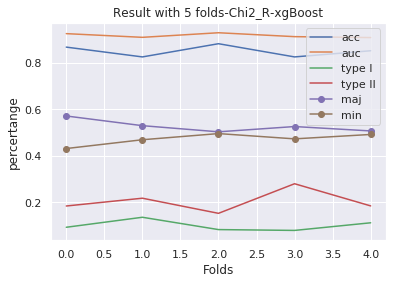

Compare Result-Bankruptcy-xgBoost


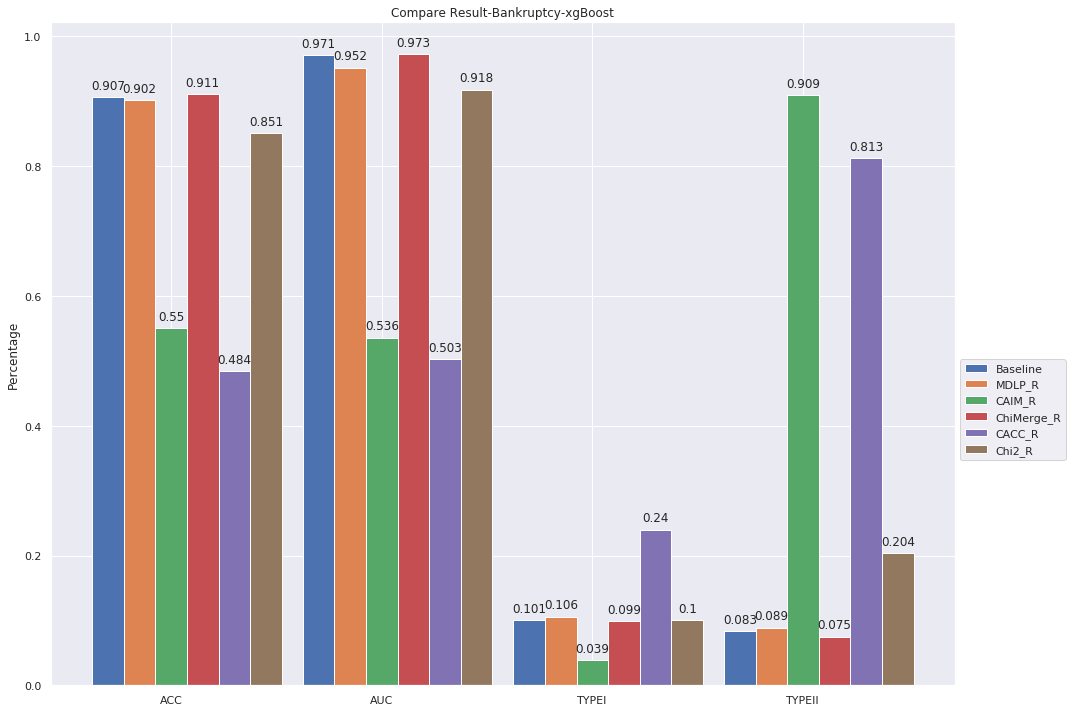

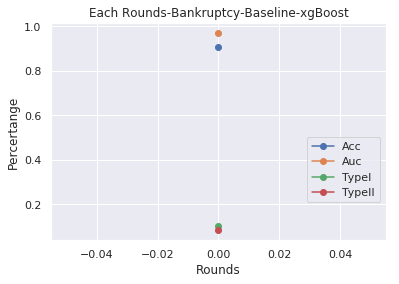

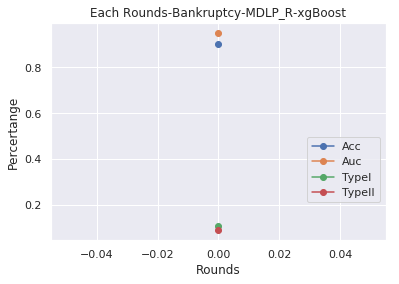

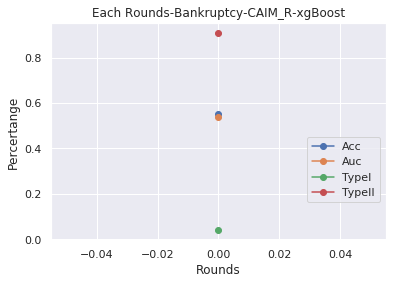

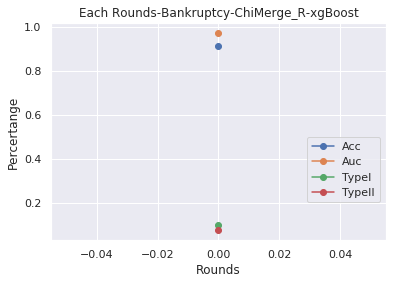

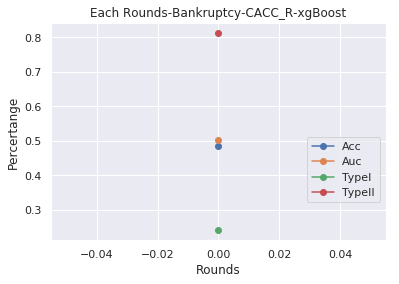

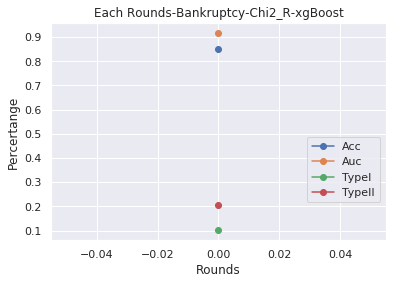

            Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline        0.91 0.97   0.10    0.08          1.24
MDLP_R          0.90 0.95   0.11    0.09         36.48
CAIM_R          0.55 0.54   0.04    0.91         34.74
ChiMerge_R      0.91 0.97   0.10    0.08       1429.16
CACC_R          0.48 0.50   0.24    0.81         37.32
Chi2_R          0.85 0.92   0.10    0.20       1428.41

程式結束
Wall time: 49min 32s


In [47]:
%%time

# Classifcation Method
linear_svc = CalibratedClassifierCV(LinearSVC(max_iter=7000))
svmlinear = SVC(kernel='linear', probability=True)
svmrbf = SVC(kernel='rbf', probability=True)
DecisionTreeClassifier = tree.DecisionTreeClassifier()
RandomForest = RandomForestClassifier()
logisticRegression = LogisticRegression()
mlp = MLPClassifier()
xgBoost = xgb.XGBClassifier()
GaussianNaiveBayes = GaussianNB()
MultinomialNaiveBayes = MultinomialNB()
ComplementNaiveBayes = ComplementNB()
lboost = LogitBoost()
ada = AdaBoostClassifier()
knn = KNeighborsClassifier()

##########################################
#svmpoly = SVC(kernel='poly', probability=True)
#neigh = KNeighborsRegressor(n_neighbors=5)
#linearRegression= LinearRegression()

#DecisionTreeClassifier,logisticRegression,mlp,xgBoost
# classifier_list = [svmrbf,DecisionTreeClassifier,RandomForest,logisticRegression,mlp,xgBoost ]
# classifier_name_list = ['svmrbf','DecisionTreeClassifier','RandomForest','LogisticRegression','MLPClassifier','xgBoost' ]
def run10times(classifier_list,classifier_name_list):

    classifier_list = [classifier_list]
    classifier_name_list = [classifier_name_list]
    classifier_result_list = []
    
    for idx,classifi in enumerate(classifier_list):
        result_list = []
        rounds = 2
        clf_name = classifier_name_list[idx]
        for i in range(1,rounds):

            result_list.clear()
            result_10times_baseline = []
            result_10times_MDLP = []
            result_10times_CAIM = []
            result_10times_ChiMerge_SC = []
            result_10times_ChiMerge_RG = []
            result_10times_CACC = []
            result_10times_Chi2 = []
            runnung_time_list = []
            #Method Select

            clf = classifi
            fold = 5

            start_time = time.time()
            result_eachtimes_baseline = KFoldFuntion(clf, clf_name, 'Baseline', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_baseline.append(result_eachtimes_baseline)
            print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0)))
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_MDLP = KFoldFuntion(clf, clf_name, 'MDLP_R', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_MDLP.append(result_eachtimes_MDLP)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_CAIM = KFoldFuntion(clf, clf_name, 'CAIM_R', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CAIM.append(result_eachtimes_CAIM)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_ChiMerge_SC = KFoldFuntion(clf, clf_name, 'ChiMerge_R', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_ChiMerge_SC.append(result_eachtimes_ChiMerge_SC)
            runnung_time_list.append(time.time() - start_time)
            
            start_time = time.time()
            result_eachtimes_CACC = KFoldFuntion(clf, clf_name, 'CACC_R', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CACC.append(result_eachtimes_CACC)
            runnung_time_list.append(time.time() - start_time)
            
            start_time = time.time()
            result_eachtimes_Chi2 = KFoldFuntion(clf, clf_name, 'Chi2_R', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_Chi2.append(result_eachtimes_Chi2)
            runnung_time_list.append(time.time() - start_time)
    
        
        # Thread Lock
        lock.acquire()
        
        
        # Compare Chart (Same Classifier)
        CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC,result_10times_CACC,result_10times_Chi2)


        # Compare Chart (Same Classifier)
        ResultEachMethodLineChart(result_10times_baseline,"Baseline",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_MDLP,"MDLP_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CAIM,"CAIM_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_ChiMerge_SC,"ChiMerge_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CACC,"CACC_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_Chi2,"Chi2_R",data_name,clf_name)

        result_list.append(np.mean(result_10times_baseline, axis=0))
        result_list.append(np.mean(result_10times_MDLP, axis=0))
        result_list.append(np.mean(result_10times_CAIM, axis=0))
        result_list.append(np.mean(result_10times_ChiMerge_SC, axis=0))
        result_list.append(np.mean(result_10times_CACC, axis=0))
        result_list.append(np.mean(result_10times_Chi2, axis=0))

        # Single Classify Method 
        result_with_method = pd.DataFrame(result_list, index=['Baseline','MDLP_R','CAIM_R','ChiMerge_R','CACC_R','Chi2_R'], columns=['Accuracy','AUC','TypeI','TypeII'])
        result_with_method['Time(Second)'] = runnung_time_list
        print(result_with_method)

        file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
        file_name = "Classifier_result_list_{fold}Fold_{data_name}_{method}_{file_timeA}.xlsx".format(fold = fold, file_timeA = file_time,data_name=data_name,method=clf_name)
        pd.DataFrame(result_with_method).to_excel("resultsexcel/"+file_name)
        
        
        # Thread Unlock
        lock.release()
    


t0 = Thread(target=run10times,args=(svmlinear,"svmlinear"))
t1 = Thread(target=run10times,args=(linear_svc,"linear_svc"))
t2 = Thread(target=run10times,args=(svmrbf,"svmrbf"))
t3 = Thread(target=run10times,args=(DecisionTreeClassifier,"DecisionTreeClassifier"))
t4 = Thread(target=run10times,args=(RandomForest,"RandomForest"))
t5 = Thread(target=run10times,args=(logisticRegression,"logisticRegression"))
t6 = Thread(target=run10times,args=(mlp,"mlp"))
t7 = Thread(target=run10times,args=(xgBoost,"xgBoost"))
t8 = Thread(target=run10times,args=(GaussianNaiveBayes,"GaussianNaiveBayes"))
t9 = Thread(target=run10times,args=(lboost,"LogitBoost"))
t10 = Thread(target=run10times,args=(ada,"AdaBoost"))
t11 = Thread(target=run10times,args=(knn,"KNN"))


#thread_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t0]
thread_list = [t7]
#thread_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11]
#thread_list = [t11,t10,t9,t7,t8]

#程式開始
for item in thread_list:
    item.start()
print("\n程式開始")


#程式結束
for item in thread_list:
    item.join()
print("\n程式結束")
    


#############################################################################YEE

## Record Result

## Compare result

print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_MDLP, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_CAIM, axis=0)))

print("Mean : {0}".format(np.mean(result_10times_ChiMerge_SC, axis=0)))

In [48]:

#ResultEachMethodLineChart(result_10times_ChiMerge_RG,"ChiMerge_RG",data_name,clf_name)